# __Search Algorithms: The Travelling Salesman Problem__
---

The [travelling salesman problem (TSP)](https://en.wikipedia.org/wiki/Travelling_salesman_problem) is one of the most famous and most studied problems in computer science. The main reason is because of its computational complexity (it belongs to the [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) category). Since 1800s, when its believed that the physicist and mathematician [W.R. Hamilton](https://en.wikipedia.org/wiki/William_Rowan_Hamilton) formulated the problem for the first time, nobody has ever discovered an algorithm able to find the optimal solution efficiently. If someone eventually does, this could have profound implications in one of the current [major unresolved problems](https://en.wikipedia.org/wiki/Millennium_Prize_Problems) in mathematics and computer science: [P vs NP](https://www.youtube.com/watch?v=EHp4FPyajKQ). This is the main reason why it's probably the best problem to test how different searching algorithms perform. 

The formulation is very simple and everyone can understand it. Imagine that you are an old-time salesman ([not a modern one](https://xkcd.com/399/)) and you want to advertise and sell your product around several cities in your country or region. The problem is the following:
>Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?.

Seems easy, right? You can try your best in [this website application](http://www.math.uwaterloo.ca/tsp/app/diy.html) from the University of Waterloo, where they also have a funny alternative version with the [shortest pub crawl](http://www.math.uwaterloo.ca/tsp/uk/index.html) around all the pubs in the UK.

As you can imagine, this is such a simple and general optimisation problem that many other specific problems from other areas, ranging from [transportation and logistics](https://en.wikipedia.org/wiki/Vehicle_routing_problem) to [biology](https://www.wired.com/2011/04/cells-math-problem/). Thus, algorithms that perform well in the abstract TSP problem could eventually help in all these other areas as well.

## Problem Formulation
---

The first step in any A.I. problem is to provide a good problem [abstraction](https://en.wikipedia.org/wiki/Abstraction_(computer_science)). Understanding what is relevant and what is meaningless in our problem, how it should be formulated in a way that a computer can operate with and how a solution should look like, are the most basic foundations. Any error in here and we might be overcomplicating the problem - potentially increasing inefficiencies - or even worse, we might get a wrong solution.

In our case we are going to attempt solving the TSP problem by representing the cities as 2D points sitting on a 100x100 canvas. In Python we are going to represent this by the variable `Cities` that will be a list of points, each with their corresponding `(x,y)` coordinates:

In [1]:
# List of 7 cities on a 100x100 canvas
Cities = [(5,60),(14,32),(17,65),(32,28),(47,18),(56,53),(92,81)]

Our particular TSP problem consist in finding the overall shortest path that joins all points of the canvas. Therefore, a candidate solution of the 7 cities above, could any [permutation](https://en.wikipedia.org/wiki/Permutation) of the numbers from 0 to 6. We will represent a candidate in the variable `Trip`, consisting in a list of integers from 0 to 6 where the first number is repeated at the last position (remember it must be a closed loop). For example, the following one:

In [2]:
# Candidate solution
Trip = [3,2,6,1,0,5,4,3]

Having a visual feedback is always a good idea, not only for understanding the problem better, but also as a double check that what we are doing makes sense and there is no flaw in our formulation. Thus, it is then very handy to have a function that plots our candidate solution alongside with the set of cities defined. It will be particularly useful when double-checking that optimised solution found by our search algorithm makes sense to us.

To do this job the `matplotlib`, a powerful and popular python library for visualization, provides all the resources we need. We will need to pass as inputs the `Cities` variable, with the x-y coordinates, and the candidate solution `Trip`. They key parts of the function below are basically plotting circles with a number in it. Then, in a layer below, plotting the segments connecting the cities according to the `Trip` variable. 

In [3]:
# Plot the cities
import matplotlib.pyplot as plt

def plot_TSP(Cities, Trip, title=None):
    """
    Plots a TSP solution in a 100 x 100 canvas
    
    Arguments:
    ----------
    Cities : List of points (x,y) within 100*100 
    Trip : Vector with the ordered sequence of cities
    title : Text for the title
    """
    
    fig, ax = plt.subplots(figsize=(6,6))
    
    # Set parameter of the axes limit and aesthetics
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.tick_params(labeltop=True, labelright=True)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    
    # Plot the cities (circles)
    for i,p in enumerate(Cities):
        
        # Get the coordinates of each point
        x,y = p

        # Create and add the circles to the canvas
        circle = plt.Circle((x, y), radius=3)
        ax.add_patch(circle)
        
        # Add the labels within the circle
        ax.annotate(i, xy=(x, y), fontsize=12, va="center", ha="center", color="white")

    # Plot the segments (Trip)
    for i in range(len(Trip)-1):
        
        # For each pair, get the coordinates from List
        p1 = Cities[Trip[i]]
        p2 = Cities[Trip[i+1]]
        
        # Create a vector for Xs and Ys
        X = [p1[0],p2[0]]
        Y = [p1[1],p2[1]]
        
        # Plot one line joining each pair
        ax.plot(X, Y, color="red", lw=3, zorder=0)
    
    # Add a title in the plot
    if title != None:
        fig.suptitle(title, fontsize=16)

    plt.show()

We can simply use the function like this:

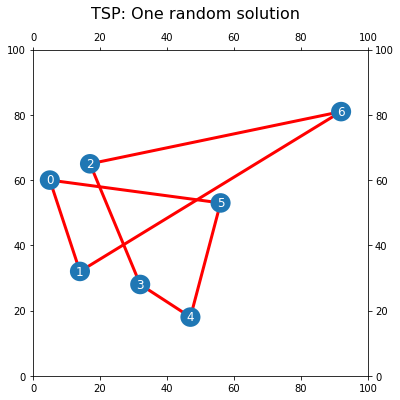

In [4]:
plot_TSP(Cities=Cities, Trip=Trip, title="TSP: One random solution")

The last necessary element we need is a way to compute the distance of a trip. Probably, the most straightforward way one could consider would be to pick each pair of numbers in the candidates' list and compute the distances sequentially for each pair of the candidate solution using a `for` loop. However, we can also quickly realise that this way we would be repeating the same calculation many times when considering different solutions. Instead, one efficient alternative could be to pre-compute all pairwise distances and store them in a matrix. Then, computing the overall distance of a candidate solution would only be adding numbers from a matrix position, which is much more efficient than calculating the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) each time. Thanks to the `distance_matrix()` function from the `scipy` library we can get this pairwise distance matrix very easily.

In [5]:
import numpy as np
from scipy.spatial import distance_matrix

# Store distances in matrix D
D = distance_matrix(Cities,Cities)
print(np.round(D,2))

[[ 0.   29.41 13.   41.87 59.4  51.48 89.5 ]
 [29.41  0.   33.14 18.44 35.85 46.96 92.11]
 [13.   33.14  0.   39.92 55.76 40.8  76.69]
 [41.87 18.44 39.92  0.   18.03 34.66 80.06]
 [59.4  35.85 55.76 18.03  0.   36.14 77.42]
 [51.48 46.96 40.8  34.66 36.14  0.   45.61]
 [89.5  92.11 76.69 80.06 77.42 45.61  0.  ]]


As you can see, the output is a symmetric matrix with zeros in the diagonal. The smallest numbers of the case above are the `D[0,2]=13.0` and `D[2,0]=13.0`, corresponding to the closest cities 0 and 2, as shown in the previous plot. The way to compute the distance of a trip is just adding up the values in the matrix for each consecutive pair of cities in the vector `Trip`. We can loop through all these pairs by using `zip(Trip[:-1], Trip[1:])`, which considers both the `Trip` vector without the last element and the same vector but shifted one position forward. Putting all these calculations in a function it is going to be useful, because this operation will be performed many times.

In [6]:
def compute_distance(Trip, D):
    """
    Computes the distance of a TSP candidate solution.
    
    Arguments:
    ----------
    Trip : Vector with the ordered sequence of cities.
    D: Pre-computed distance matrix.
    
    Returns:
    --------
    The overall distance value in a float number.
    """
    total_distance = 0
    for A, B in zip(Trip[:-1], Trip[1:]):
        total_distance += D[A, B]
    return(total_distance)

distance = compute_distance(Trip,D)
print(np.round(distance,2))

343.78


Additionally, we can pass useful information, such as the number of cities, the candidate number and the total distance, into the function that does the plot. This information can be shown in the title's plot on the top.

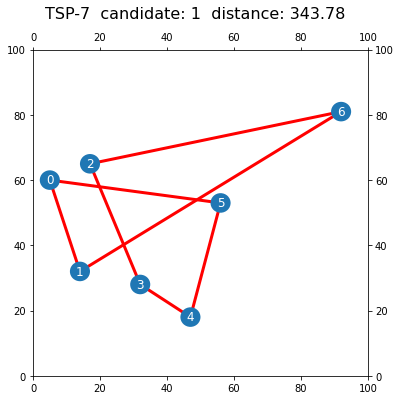

In [7]:
candidate_num = 1

# Generate a string of text with useful information
text = "TSP-" + str(len(Cities)) + "  candidate: " + str(candidate_num) + "  distance: " + str(np.round(distance,2))

plot_TSP(Cities=Cities, Trip=Trip, title=text)

Thus, we have now created a good abstraction of the TSP problem that allows us to define a specific TSP configuration, provide a candidate solution, compute the distance of this candidate and give a visual feedback of it. The problem is now ready to start the real challenge, searching the optimal candidate in an efficient way. 

<div class="alert alert-block alert-info"><b>Exercise 1:</b><br> Create a function that generates a random TSP in a 2D squared space, given a number of cities and the size of the edge. The function should return both the list with cities' coordinates and the distance matrix. Then, as a test, generate TSP with 15 cities and plot a solution including the distance. You can use the functions already created in this notebook.<br><br><i>Hint: Checkout <a href="https://docs.python.org/3/library/random.html">the functions</a> within the python package "random" and which one would be useful in our case.</i></div>

## Depth-first search
---

Let's start by designing an algorithm that finds a solution by brute force. Of course, this might seem the opposite of Artificial Intelligence, but is still a way to get to the solution and it can also be useful as a benchmark for evaluating other searching algorithms. All brute-force algorithms check each possible solution one by one in a specific order. How we define this order, i.e. what rules we apply follow to explore the different tree branches one by one, defines which search algorithm we are using.

Checking all the cases means computing the distance for all possible combinations of vectors, such as the one in variable `Trip` above. In mathematics we call this exploring all the permutations. The number of permutations $\Pi$ for the TSP is well defined:

$\Pi = (N-1)!=(N-1)\times(N-2)\times(N-3)\times\dots\times2\times1$,

where $N$ is the number of cities to visit. Notice that it is not $N!$ because we are imposing that trips start and end in the same city forming a closed loop. Thus, the loop 0 &#8594; 1 &#8594; 2 &#8594; 3 &#8594; 0 is the same trip than 1 &#8594; 2 &#8594; 3 &#8594; 0 &#8594; 1. This of course reduces the number of combinations, and, since we need to go through all cities, we can impose to always start with the city 0.

The depth-first search (DFS) - [do not confuse](https://xkcd.com/2407/) with [breadth-first search](https://en.wikipedia.org/wiki/Breadth-first_search) - explores first the most left branch of the tree all the way down. Then it continues going up and right from the bottom. In our configuration this would be equivalent to start from the permutation `[1,2,3,4,5,6]` - the corresponding trip starts and ends with 0 - and then change systematically the permutations from the tail.

The function `permutations` from the `itertools` package suits perfectly here since the permutations are generated in this precise order. Let's see what it does with a much more simple case of 4 cities, before implementing it on our TSP with 7 cities, .

In [8]:
from itertools import permutations

# Example with vectors with size 4
perm = [1,2,3]
for p in list(permutations(perm)):
    Trip = [0] + list(p) + [0]
    print(Trip)

[0, 1, 2, 3, 0]
[0, 1, 3, 2, 0]
[0, 2, 1, 3, 0]
[0, 2, 3, 1, 0]
[0, 3, 1, 2, 0]
[0, 3, 2, 1, 0]


If you pick a pencil a piece of paper and draw the branching tree where the lowest value is always on the left, you will quickly see that this is the exact order of the different configurations for the depth-first search algorithm.

Let's implement this algorithm in a function that takes the list `Cities`, the distance matrix `D`. In each iteration take the corresponding permutation and ad the first number to the end in order to close the loop. This is how we create the variable `Trip` and calculate its corresponding distance. If that distance is lower than our best candidate's distance, then we replace it. At the end of the loop or when we have reached a certain number of iterations defined by the argument `max_it`, the function will return the best candidate solution, its distance value and a data frame with the candidate distance in each round.

In [9]:
import pandas as pd

def depth_first_search(Cities,D,max_it=10000):
    """
    Finds a solution of TSP using depth-first search.
    
    Arguments:
    ----------
    Cities : List of points (x,y). 
    D: Pre-computed distance matrix.
    max_it: Maximum number of iterations.
    
    Returns:
    --------
    - Best candidate Trip
    - Best candidate round found
    - Data frame with round number and distance
    
    """

    # Create root for first candidate
    root = list(range(1,len(Cities)))
    # Add the first node at both ends
    best = [0] + list(root) + [0]
    # Compute distance
    best_dist = compute_distance(best,D)

    # Counter
    i = 1
    
    # List for storing information for the df
    info = [[i,best_dist]]
    
    for perm in permutations(root):
        # Increase the counter
        i += 1
        # end loop if we reach max_it iterations
        if i >= max_it:
            break
        
        Trip = [0] + list(perm) + [0]
        d = compute_distance(Trip,D)
        
        if d < best_dist:
            best = Trip
            best_dist = d
            info.append([i,best_dist])

    df = pd.DataFrame(info,columns=["round","distance"])
    # Get the last round where best candidate appeared
    best_round = info[-1][0]
    return(best,best_round,df)

# Run the function
sol,sol_round,df_dfs = depth_first_search(Cities,D,10000)
# Print the candidate
print("Depth-first search candidate (round " + str(sol_round) + "): " + ' '.join(str(sol)))
# Show first candidates distance
df_dfs.head(20)

Depth-first search candidate (round 35): [ 0 ,   1 ,   3 ,   4 ,   5 ,   6 ,   2 ,   0 ]


,round,distance
0,1,291.743894
1,19,286.275921
2,25,280.876882
3,35,237.311045


Let's have a look at the solution reached:

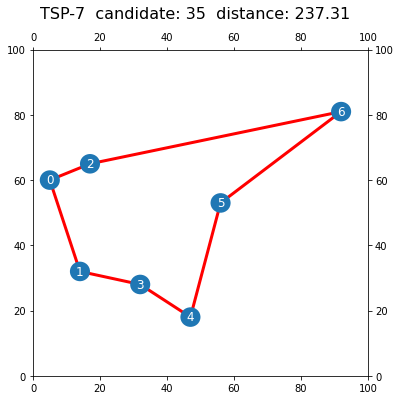

In [10]:
# Get values from df_rsearch
distance = df_dfs.tail(1)["distance"].values[0]
# Generate title text
text = "TSP-" + str(len(Cities)) + "  candidate: " + str(sol_round) + "  distance: " + str(np.round(distance,2))
# Use plot_TSP()
plot_TSP(Cities=Cities, Trip=sol, title=text)

Indeed, the solution found looks good. The algorithm has found the optimal solution in the round 34. It is also interesting to check how quickly the distance of the best candidate decays as rounds go along. This curve is also called [loss function](https://en.wikipedia.org/wiki/Loss_function) and useful for providing a sense of how quick or efficient is the algorithm when finding the best candidate. The data frame `df_dpfst` returned from the `depth_first_search()` function conveniently contains all the necessary information for this plot. 

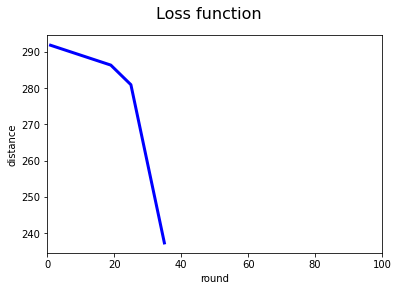

In [11]:
fig, ax = plt.subplots(figsize=(6,4))

# Plot's title
fig.suptitle("Loss function", fontsize=16)

# Plot one line joining each pair
ax.plot(df_dfs["round"], df_dfs["distance"], color="blue", lw=3)

ax.set_xlim(0,100)

# Set labels
ax.set_ylabel("distance")
ax.set_xlabel("round")

plt.show()

<div class="alert alert-block alert-info"><b>Exercise 2:</b><br> Think of an algorithm that implements the breadth-first search (BFS) for this formulation of the TSP. Use pencil and paper for drawing flowcharts or pseudocode if you need it. Then try to implement it in Python by creating a function called breadth_first_search() with distance matrix and the cities as inputs. Alert: When testing it do not use large number of cities. This could fill up entirely your RAM memory and you'd need to restart your computer.<br><br><i>Hint: When building trip sequences, it might be useful to get all the elements of the list A that are not in the list B. You can do it with the following command:<br><br>item_list = [a for a in A if a not in B]<br><br>Checkout <a href="https://stackoverflow.com/questions/36268749/remove-multiple-items-from-a-python-list-in-just-one-statement">this post</a> in Stack Overflow.</i>.</div>

## Random search
---

Another interesting algorithm to consider for TSP is the [random search](https://en.wikipedia.org/wiki/Random_search), where we check one random permutation at a time. Statistically speaking [Depth-first search algorithm](#Depth-first-search) and this one have the same chances to find the optimal solution in each round, assuming we don't have any extra information. However, their appropriateness differ depending whether we plan to explore all solutions or not, which for high number of cities might be something we want to consider. If we do, it is of course optimal to know the distance of each of the candidates and take the shortest one. If we don't, we might argue that the random search is better because the variability of the solutions will be higher. For 7 cities, the number of candidates is 720, something achievable almost instantly for a standard computer. However, for 15 cities we have already 87,178,291,200 or around 87 billion candidates to check. If we plan to increase the number of cities, we know that we won't be able to explore all possibilities and our depth-first search will only explore a small subset of those, all of them probably starting with the same sequence. If we want to at least explore trips starting with different sequences, then we have a good reason to choose random search.

Fortunately, `numpy` makes our lives very easy by letting us use the `random.permutation()` function, which returns a random sequence of N numbers.  

In [12]:
def random_search(Cities,D,max_it):
    """
    Finds a solution of TSP using random search.
    
    Arguments:
    ----------
    Cities : List of points (x,y). 
    D: Pre-computed distance matrix.
    max_it: Maximum number of iterations.
    
    Returns:
    --------
    - Best candidate Trip
    - Best candidate round found
    - Data frame with round number and distance
    
    """
    
    # Create root for permutations
    root = list(range(1,len(Cities)))
    # Start with a random permutation
    rperm = np.random.permutation(root)
    # Add the first node at both ends
    cand = [0] + list(rperm) + [0]
    # Compute distance
    cand_dist = compute_distance(cand,D)
    
    # List for storing information for the df
    info = [[1,cand_dist]]
    
    for i in range(2,max_it):
        rperm = np.random.permutation(root)
        Trip = [0] + list(rperm) + [0]
        d = compute_distance(Trip,D)
        
        if d < cand_dist:
            cand = Trip
            cand_dist = d
            # Append information when better candidate found
            info.append([i,cand_dist])
    
    df = pd.DataFrame(info, columns=["round","distance"])
    # Get the last round where best candidate appear
    cand_round = info[-1][0]
    return(cand,cand_round,df)

# Run the function
sol,sol_round,df_rsearch = random_search(Cities,D,5000)
# Print the candidate
print("Random search candidate (round " + str(sol_round) + "): " + ' '.join(str(sol)))
# Show first candidates distance
df_rsearch.head(10)

Random search candidate (round 1029): [ 0 ,   1 ,   3 ,   4 ,   5 ,   6 ,   2 ,   0 ]


,round,distance
0,1,291.743894
1,4,287.389303
2,24,287.268984
3,28,281.535214
4,39,278.115938
5,71,270.348940
6,86,253.847171
7,99,253.235678
8,775,242.710084
9,1029,237.311045


Let's see whether the solution makes sense.

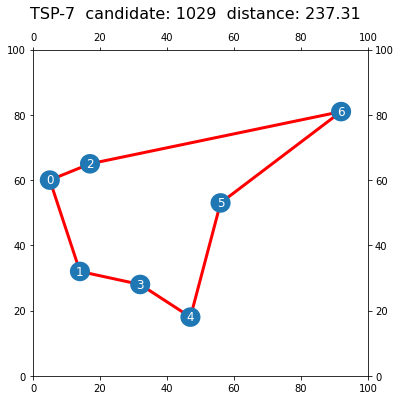

In [13]:
# Get values from df_rsearch
distance = df_rsearch.tail(1)["distance"].values[0]
# Generate title text
text = "TSP-" + str(len(Cities)) + "  candidate: " + str(sol_round) + "  distance: " + str(np.round(distance,2))
# Use plot_TSP()
plot_TSP(Cities=Cities, Trip=sol, title=text)

It does, but this algorithm has taken many more rounds to find the solution in this case. Also, bear in mind that the result above will change if you re-run the code given its random nature. It can even provide a sub-optimal solution many of the times. Of course, the more cities we generate, the worse the solutions will be, or conversely, the longer it will take to find a the solution.

<div class="alert alert-block alert-info"><b>Exercise 3:</b><br>Study how the algorithms "Breadth-first search", "Depth-first search" and "Random search" perform in terms of finding the best solution and the execution time. To do so, study TSP with different number of Ncities from 4 to 10. For each Ncities value, generate 50 different TSPs and run all three algorithms for each case. In each algorithm execution measure the execution time and which algorithm has found the shortest trip. For each Ncities value provide the number of times each algorithm has found the shortest path and the average execution time. In case of ties between algorithms account consider the winners all two or all three. Finally, provide the results in a data frame and think about the results. Which is the faster algorithm? Which is the most accurate one? What happens when we increase the number of cities?<br><br><i>Hint: You can easily calculate the execution time using the function time() of the python package "time". Checkout <a href="https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python">this useful example</a> from Stackoverflow.</i></div>

Now, after having seen some numbers for depth-first search and random search algorithms, it is quite clear that finding "the best" solution becomes quickly an intractable problem as we increase the number of cities. This at the end is the nature of NP-hard problems. Is there anything we can do about or should we just give up and resign ourselves to explore all the options?

Well, if our goal is still to find "the best" solution [there are algorithms](#Some-other-efficient-algorithms) that make this process more efficient. Instead, if what we are after is finding a solution that it is "good enough", then there is plenty of room to create algorithms based on arguments that produce good approximations. This way of working is called [heuristics](https://en.wikipedia.org/wiki/Heuristic) and our brain is constantly doing it. The next two searching algorithms are clear examples of that.

## Greedy search
---

Before starting the search for each of the possible trips, we compute the distance matrix `D` that we then pass to our algorithms as an object that they use to compute the the actual distance of each candidate. This matrix contains useful information, that we can use in order to explore good candidates efficiently. Indeed, one could think that connecting neighbouring cities has a bigger chance to produce a low distance path than connecting far-away cities. This is precisely the idea behind the [greedy search](https://en.wikipedia.org/wiki/Greedy_algorithm), in each step the next city that we are going to add to our trip is the closest one that we haven't visited yet.

Obtaining the distances to all nodes using the distance matrix is straightforward. In the example above, we can get all distances from the node 3 by just selecting the third row `D[3,]`. However, what we really need is to sort all nodes by its distance to the node 3, then pick the first one that we have not visited yet. The function `argsort()` from the `numpy` package is very convenient here, since it returns the indexes of the elements sorted by its value. For checking whether an element is not within list `not in` is the condition we need to put in the `if` statement.

The greedy search is deterministic, which means that the candidate trip will always be the same provided a starting city. Thus, it makes a lot of sense to create a function that takes as an argument one of the cities as starting point and creates the only one possible trip based in the nearest neighbour rule. 

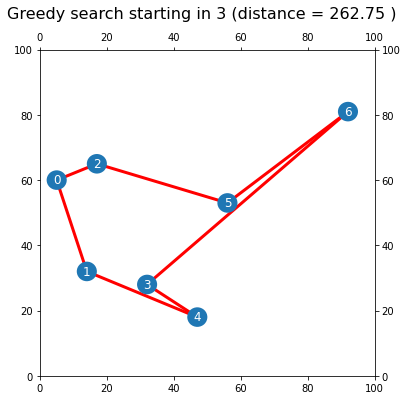

In [14]:
def nearest_neighbour_trip(start, Cities, D):
    """
    Finds the trip based on nearest neighbour.
    
    Arguments:
    ----------
    start: Starting city.
    Cities : List of points (x,y). 
    D: Pre-computed distance matrix.
    
    Returns:
    --------
    List with trip sequence.
    """
    # Create a list with visited cities with start in it
    visited = [start]
    # Pos variable will control the current city
    current = start
    
    # loop until we visit all cities
    while len(visited) < len(Cities):
        # Order cities by closeness to current city
        sorted_idxs = np.argsort(D[current,])
        
        #Loop through all those
        for i in sorted_idxs:
            # If the city is already visited skip to next
            if i not in visited:
                # Otherwise append this one to visited
                visited.append(i)
                # Set the current city to this one
                current = i
                # Exit the for loop and check from next city
                break
    
    # Add the start city to the end
    visited = visited + [start]
    return(visited)

# Run the function for city 3
Trip = nearest_neighbour_trip(3, Cities, D)
d = compute_distance(Trip,D)
plot_TSP(Cities=Cities, Trip=Trip, title="Greedy search starting in 3 (distance = " + str(round(d,2)) + " )")

As you can see above, the solution provided when starting from the node 3 is not optimal. In fact, the greedy search will normally produce a sub-optimal solution. However, the distance of the first candidate is already quite low compared with the distance of the first candidate in the other cases.

Let's build the function that produces the all the greedy search candidates. To do so we only need to loop through all cities and use the `nearest_neighbour_trip()` we have coded above. Then, like in the other algorithms, we will keep the shortest one as the best candidate. 

In [15]:
def greedy_search(Cities, D):
    """
    Finds a solution of TSP using greedy search.
    
    Arguments:
    ----------
    Cities : List of points (x,y). 
    D: Pre-computed distance matrix.
    max_it: Maximum number of iterations.
    between samples. 
    
    Returns:
    --------
    - Best candidate Trip
    - Best candidate round found
    - Data frame with round number and distance
    
    """

    # Compute distance
    cand_dist = 0
        
    dist = []
    
    # Candidate round
    cand_round = 1
    
    for i in range(len(Cities)):
        # Get starting city
        start = i
        # Get the NN-Trip
        Trip = nearest_neighbour_trip(start, Cities, D)
        # Compute the distance
        d = compute_distance(Trip,D)
        # If distance is best or i is first iteration
        if d < cand_dist or cand_dist == 0:
            cand = Trip
            cand_dist = d
            cand_round = i + 1

        dist.append(cand_dist)
    
    df = pd.DataFrame({'round':np.arange(len(Cities)) + 1, 'distance':dist})
    return(cand,cand_round,df)

# Run the function
sol,sol_round,df_greedy_search = greedy_search(Cities=Cities,D=D)
# Print the candidate
print("Greedy search candidate (round " + str(sol_round) + "): " + ' '.join(str(sol)))
# Show first candidates distance
df_greedy_search.head(10)

Greedy search candidate (round 3): [ 2 ,   0 ,   1 ,   3 ,   4 ,   5 ,   6 ,   2 ]


,round,distance
0,1,253.847171
1,2,253.847171
2,3,237.311045
3,4,237.311045
4,5,237.311045
5,6,237.311045
6,7,237.311045


With this specific TSP configuration we eventually reach the optimal solution with the greedy search. However, you can test yourselves that this is not always the case if you just shuffle the cities again, or you increase the number of cities. Another remarkable weakness is the limited amount of candidates generated, which is equal to the number of cities - one per starting point. Such a limited set of options is probably not the best tool to find the best solution, but it definitely excels finding a good candidate relatively quickly. 

## 2-opt algorithm
---

Another set of algorithms consists in finding a way to improve a candidate, rather than finding it from scratch. This is the case of the [2-opt algorithm](https://en.wikipedia.org/wiki/2-opt) whose main point is to swap edges of an already provided solution. The intuitive mechanism of this search is that removes the crossings between edges, which tends to reduce the distance significantly. For example, let's consider the Trip below:

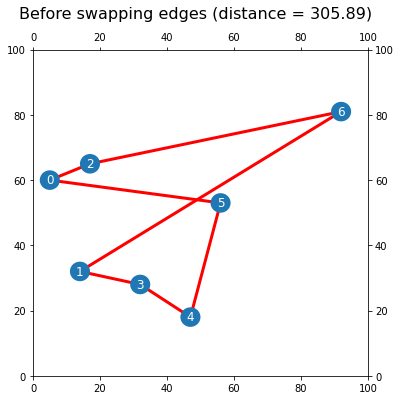

In [16]:
# Candidate solution
Trip = [2, 0, 5, 4, 3, 1, 6, 2]
d = compute_distance(Trip,D)
text = "Before swapping edges (distance = " + str(round(d,2)) + ")"
plot_TSP(Cities=Cities, Trip=Trip, title=text)

It's quite clear that the solution could be improved by removing the crossing between edges 0 &#8594; 5 and 1 &#8594; 6. Note that removing those edges and then reconnecting them, such that 0 &#8594; 1 and 5 &#8594; 6, also implies reversing the direction of the segment 5 &#8594; 4 &#8594; 3 &#8594; 1. To make this swapping simple we can write a function `edge_swap()` that uses the position of the cities the edges are pointing to in the `Trip` variable, which in our particular case (cities 5 and 6) is 2nd and 6th respectively. 

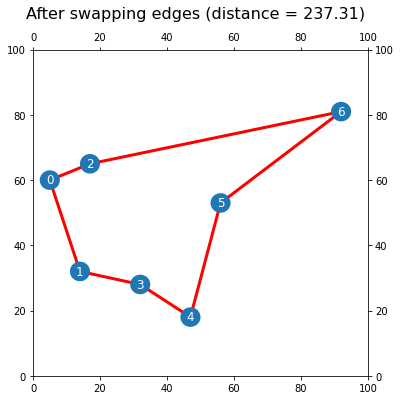

In [17]:
def edge_swap(Trip, i, j):
    """
    Swaps edges into nodes i and j of a TSP closed trip.
    
    Arguments:
    ----------
    Trip : List with the ordered sequence of cities. 
    i: ith position of the destination node in Trip.
    j: jth position of the destination node in Trip.
    
    Returns:
    --------
    New Trip with edges swapped
    
    """
    # Copy the old Trip
    newTrip = Trip[:]
    # Reverse the order of the segment from i to j
    newTrip[i:j] = Trip[j-1:i-1:-1]
    return newTrip;

newTrip = edge_swap(Trip, 2, 6)
d = compute_distance(newTrip,D)
text = "After swapping edges (distance = " + str(round(d,2)) + ")"
plot_TSP(Cities=Cities, Trip=newTrip, title=text)

As you can see above, this function has successfully swapped the mentioned edges and returned the optimal solution 2 &#8594; 0 &#8594; 1 &#8594; 3 &#8594; 4 &#8594; 5 &#8594; 6 &#8594; 2. Of course, it could still happen that there are many more crossings in our path. Therefore, we need to scan all edges keeping only the configuration when that reduces the overall distance. Visiting all edges just once, might not be enough with still some room to optimise our configuration further. The 2-opt algorithm sweeps all edges several times until the configuration does not longer improve. 

In [18]:
def two_opt_search(Cities, D, max_it=10000):
    """
    Finds a solution of TSP using 2-opt algorithm.
    
    Arguments:
    ----------
    Cities : List of points (x,y). 
    D: Pre-computed distance matrix.
    max_it: Maximum number of iterations.
    
    Returns:
    --------
    - Best candidate Trip
    - Best candidate round found
    - Data frame with round number and distance
    
    """
    
    # Create root for permutations
    root = list(range(1,len(Cities)))
    # Start with a random permutation
    rperm = np.random.permutation(root)
    # Add the first node at both ends
    cand = [0] + list(rperm) + [0]
    # Compute distance
    cand_dist = compute_distance(cand,D)
    
    dist = [cand_dist]
    
    # Candidate round
    cand_round = 1
    
    improvement = True
    while improvement:
        improvement = False
        for i in range(1, len(Cities)-1):
            for j in range(i + 1, len(Cities) + 1):
                if j-i == 1:
                    continue # Do not swap for consecutive cites
                
                cand_round += 1 # Add one round for each swap
                newTrip = edge_swap(cand, i, j)
                d = compute_distance(newTrip,D)
                if d < cand_dist:
                    cand = newTrip
                    cand_dist = d
                    improvement = True
                
                dist.append(cand_dist)


    print(len)
    df = pd.DataFrame({'round':np.arange(1,len(dist)+1), 'distance':dist})
    return(cand,cand_round,df)

# Run the function
sol,sol_round,df_twoopt_search = two_opt_search(Cities=Cities,D=D)
# Print the candidate
print("2-opt search candidate (round " + str(sol_round) + "): " + ' '.join(str(sol)))
# Show first candidates distance
df_twoopt_search.head(10)

<built-in function len>
2-opt search candidate (round 61): [ 0 ,   2 ,   6 ,   5 ,   4 ,   3 ,   1 ,   0 ]


,round,distance
0,1,330.676017
1,2,330.676017
2,3,330.676017
3,4,330.676017
4,5,330.676017
5,6,330.676017
6,7,330.676017
7,8,285.774011
8,9,285.774011
9,10,278.410248


## Some other efficient algorithms
---

Network theory has also developed methodologies that are very useful for this problem, considering that each city as nodes and the distance matrix an equivalent of the adjacency matrix, creating thus a weighted network. The [Minimum Spanning Tree (MST)](https://en.wikipedia.org/wiki/Minimum_spanning_tree) is the graph that connects, without cycles, all vertices of the network whose weight (euclidean distances in our case) is minimum. The use of the MST is central in the so-called [Christofides-Serdyukov algorithm](https://en.wikipedia.org/wiki/Christofides_algorithm), watch [this video](https://www.youtube.com/watch?v=xN9ZtYzPewg) for a good explanation. This algorithm guarantees that its proposed solutions are never going to be 1.5 longer that the optimal solution, which makes it a very good system to find good approximations in a quick way. You can find its implementation in Python in [this](https://github.com/MUSoC/Visualization-of-popular-algorithms-in-Python/tree/master/Travelling%20Salesman%20Problem) GitHub repository.

The most efficient general solution proposed so far is the [Held-Karp algorithm](https://en.wikipedia.org/wiki/Held%E2%80%93Karp_algorithm) proposed by Michael Held and Richard Karp in 1962. This algorithm uses [dynamic programming](https://en.wikipedia.org/wiki/Dynamic_programming), which is a method that consists in breaking down the big problem in several recursive sub-problems. This allows identifying some repeated sub-problems, and only compute the answer once for those cases. [This video](https://www.youtube.com/watch?v=_51ot-Ri0ng) beautifully explains how this algorithm works and why has the lowest computation complexity known so far for solving the TSP problem: $O(n^2 \times 2^n)$

<div class="alert alert-block alert-info"><b>Exercise 4:</b><br>Performing an A* search in the TSP problem is not straight forward. Remember that we need to define an overall measure f(n)=g(n)+h(n) to minimize, where g(n) is the edge cost, as in the greedy search, and h(n) is an heuristic measure that is tipically attached to the nodes. Note that here we cannot simply use the <a href="https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm"> Dijkstra's algorithm</a> for h(n), since we do not want to know the shortest route between A and B but the shortest route that passes through all nodes. However, there is still a valid heuristic measure for h(n) that we can use: That is the Minimum Spanning Tree distance of all unvisited nodes + the nearest distance from any unvisited node to the start.<br><br>Knowing all this information, could you implement the A* search version for the TSP?<br><br><i>Hint: You can adapt the nearest_neighbour_trip() function to sort the index according to the f(n) measure defined below, rather than just g(n) (edge cost). For computing the Minnimum Spanning Tree you can use <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.minimum_spanning_tree.html">this function from scipy</a>.Note that the overall distance is just the sum of all the elements of the matrix.</i><br><br>*This is a difficult exercise, make sure you have completed the other ones before attempting this one.</div>

---
<div style="text-align: right ;font-size: small; color: gray"> Notebook by <a href="http://mariogutierrezroig.net">Mario Gutiérrez-Roig</a>, Lecturer in Data Science and Statistics at the University of Essex <a href="http://creativecommons.org/licenses/by-sa/4.0/" rel="license"><img src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" alt="Licencia de Creative Commons" hspace="10" align="right"></a></div>